# Logistic regression

The reinterpretation of classification methods as a form of regression on probability quickly leads to the question of looking for other ways to perform that regression. Specifically, can linear regression be adapted to that purpose? The answer is a qualified "yes".

A linear regressor is the function $f(\bfx) = \bfx^T \bfw$ for a constant vector $\bfw$ (where we may augment $\bfx$ with a constant in order to incorporate the intercept). It's not a good candidate for representing a probability, which should vary between 0 and 1. A simple remedy is to transform its output using the **logistic function**, which is defined as

$$
\sigma(x) = \frac{1}{1+e^{-x}}.
$$

```{figure} ../_static/logistic.png
```

The logistic function has the real line as its domain and takes the form of a smoothed step up from 0 to 1. Its inverse is the **logit function**,

$$
\logit(p) = \ln\left( \frac{p}{1-p} \right).
$$

```{figure} ../_static/logit.png
```

When interpreting $p$ as probability, $\logit(p)$ is the **log-odds ratio**. For instance, if $p=2/3$, then the odds ratio is $(2/3)/(1/3)=2$ (i.e., 2:1 odds), and $\logit(2/3)=\ln(2)$. 

A natural use of linear regression, which has a range over all real numbers, is to match it to the logit of probability, rather than to probability itself:

$$
\logit(p) \approx \bfx^T\bfw.
$$

This implies multilinear regression for the function $\logit(p)$, where $p$ is the probability of the class $y=1$. Equivalently,

$$
p \approx \sigma(\bfx^T\bfw).
$$

The resulting method is called **logistic regression**.

## Loss function

At each training observation $(\bfx_i,y_i)$, we know that either $y_i=0$ or $y_i=1$. Extending the loss function for linear regression to the logistic case would suggest the minimization of least squares,

$$
\sum_{i=1}^n \left[ \bfx_i^T\bfw - \logit(y_i) \right]^2. 
$$

However, the logits in this expression are all infinite, so a different loss function must be identified. One possibility is 

$$
\sum_{i=1}^n \left[ \hat{p}_i - y_i \right]^2, \qquad \hat{p}_i = \sigma(\bfx_i^T\bfw) .
$$

It's more common to minimize the **cross-entropy** loss function

$$
L(\bfw) = -\sum_{i=1}^n \left[ y_i \log(\hat{p}_i) + (1-y_i) \log(1-\hat{p}_i) \right].
$$

The logarithms above can have any base, since that only changes $L$ by a constant factor. Note that in cross-entropy, observation $i$ contributes $-\log(1-\hat{p}_i)$ if $y_i=0$ and $-\log(\hat{p}_i)$ if $y_i=1$. This loss function creates an unboundedly large penalty as $\hat{p}_i \to 1$ if $y_i=0$, and vice versa, which often makes it preferable to the least-squares alternative above.

Logistic regression does have a major disadvantage compared to (multi)linear regression: the minimization of loss does *not* lead to a linear problem for the weight vector $\bfw$. The difference in practice is usually not concerning, though. As with other forms of regression, the loss function may be regularized using the ridge or LASSO penalty. As we covered earlier, there is a regularization parameter $C$ that emphasizes small $\norm{\bfw}$ as $C\to 0$, and pure regression as $C\to \infty$. 

## Case study: Personal spam filter

We will try logistic regression for a simple spam filter. The data set is based on work and personal emails for one individual. The features are calculated word and character frequencies, as well as the appearance of capital letters.

In [1]:
import pandas as pd
spam = pd.read_csv("spambase.csv")
spam

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,char_freq_%3B,char_freq_%28,char_freq_%5B,char_freq_%21,char_freq_%24,char_freq_%23,capital_run_length_average,capital_run_length_longest,capital_run_length_total,class
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.000,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.000,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.010,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.000,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.000,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4596,0.31,0.00,0.62,0.0,0.00,0.31,0.00,0.00,0.00,0.00,...,0.000,0.232,0.0,0.000,0.000,0.000,1.142,3,88,0
4597,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,...,0.000,0.000,0.0,0.353,0.000,0.000,1.555,4,14,0
4598,0.30,0.00,0.30,0.0,0.00,0.00,0.00,0.00,0.00,0.00,...,0.102,0.718,0.0,0.000,0.000,0.000,1.404,6,118,0
4599,0.96,0.00,0.00,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.000,0.057,0.0,0.000,0.000,0.000,1.147,5,78,0


We'll create a feature matrix and label vector, and split into train/test sets.

In [2]:
X = spam.drop("class",axis="columns")
y = spam["class"]

from sklearn.model_selection import train_test_split
X_tr,X_te,y_tr,y_te = train_test_split(X,y,test_size=0.2,shuffle=True,random_state=1)

When using norm-based regularization, it's good practice to standardize the variables, so we will prepare to set up a pipeline.

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

First we use a large value of $C$ to emphasize the regressive loss rather than the regularization penalty. (The default regularization norm is the 2-norm.) It's not required to select a solver, but we choose one here that is reliable for small data sets.

In [4]:
from sklearn.linear_model import LogisticRegression
logr = LogisticRegression(C=100,solver="liblinear")
pipe = make_pipeline(StandardScaler(),logr)
pipe.fit(X_tr,y_tr)
pipe.score(X_te,y_te)

0.9337676438653637

Let's look at the most extreme regression coefficients.

In [5]:
pd.Series(logr.coef_[0],index=X.columns).sort_values()

word_freq_george             -24.055873
word_freq_cs                  -8.573934
word_freq_hp                  -3.512677
word_freq_meeting             -1.940974
word_freq_lab                 -1.469316
word_freq_edu                 -1.460705
word_freq_hpl                 -1.181911
word_freq_85                  -1.177344
word_freq_re                  -0.981293
word_freq_conference          -0.934152
word_freq_project             -0.776980
word_freq_pm                  -0.477826
char_freq_%3B                 -0.379451
capital_run_length_average    -0.367801
word_freq_data                -0.346597
word_freq_labs                -0.287406
word_freq_original            -0.271247
char_freq_%5B                 -0.209782
word_freq_address             -0.196341
word_freq_table               -0.183580
word_freq_parts               -0.165103
word_freq_direct              -0.135774
word_freq_will                -0.132897
word_freq_1999                -0.124816
word_freq_make                -0.110128


The word "george" is a strong counter-indicator for spam (remember that this data set comes from an individual), while the presence of "free" or consecutive capital letters is a strong signal of spam. 

The predictions by the regressor are all either 0 or 1. But we can also see the forecasted probabilities before rounding.

In [6]:
print("classes:")
print(pipe.predict(X_tr.iloc[:5,:]))
print("\nprobabilities:")
print(pipe.predict_proba(X_tr.iloc[:5,:]))

classes:
[0 0 0 0 0]

probabilities:
[[0.53769264 0.46230736]
 [0.99694715 0.00305285]
 [0.63975661 0.36024339]
 [0.996342   0.003658  ]
 [0.93740435 0.06259565]]


The probabilities might be useful for making decisions based on the results. They can also be used to create an ROC curve.

For a validation-based selection of the best regularization parameter value, we can use `LogisticRegressionCV`.

In [7]:
from sklearn.linear_model import LogisticRegressionCV
logr = LogisticRegressionCV(Cs=40,cv=5,solver="liblinear")
pipe = make_pipeline(StandardScaler(),logr)
pipe.fit(X_tr,y_tr)

print(f"best C value: {logr.C_[0]:.3g}")
print(f"R2 score: {pipe.score(X_te,y_te):.4f}")

best C value: 21.5
R2 score: 0.9349


## Multiclass case

When there are more than two unique labels possible, logistic regression can be extended through the **one-vs-rest** (OVR) paradigm. Given $K$ classes, there are $K$ binary regressors fit for the outcomes "class 1/not class 1," "class 2/not class 2," and so on, giving $K$ different coefficient vectors, $\bfw_k$. Now for a sample point $\bfx_i$ we predict probabilities for it being in each class:

$$
\hat{q}_{i,k} = \sigma(\bfx_i^T \bfw_k), \qquad k=1,\ldots,K. 
$$

Since the $K$ OVR regressors are done independently, there is no reason to think these probabilities will sum to 1 over all the classes. But it's easy to normalize them:

$$
\hat{p}_{i,k} = \frac{\hat{q}_{i,k}}{\sum_{k=1}^K \hat{q}_{i,k}}.
$$

That is, we get a matrix of probabilities. Each of the $n$ rows gives the class probabilities at a single sample point, and each of the $K$ columns gives the probability of one class at all the samples.


## Case study: Gas sensor drift

As a multiclass example, we use a data set about gas sensors recording values over long periods of time.

In [8]:
gas = pd.read_csv("gas_drift.csv")
y = gas["Class"]
X = gas.drop("Class",axis="columns")
X_tr,X_te,y_tr,y_te = train_test_split(X,y,test_size=0.2,shuffle=True,random_state=1)

logr = LogisticRegression(solver="liblinear")
pipe = make_pipeline(StandardScaler(),logr)
pipe.fit(X_tr,y_tr)
print("CofD score:",pipe.score(X_te,y_te))

CofD score: 0.98705966930266


We can now look at predictions of probability for each class.

In [9]:
import pandas as pd
p_hat = pipe.predict_proba(X_te)
results = pd.DataFrame(p_hat,columns=["Class "+str(i) for i in range(1,7)])
results

,Class 1,Class 2,Class 3,Class 4,Class 5,Class 6
0,0.000153,5.335916e-06,0.020479,4.207813e-03,0.003191,9.719636e-01
1,0.000004,9.999199e-01,0.000074,6.812814e-07,0.000002,5.883007e-17
2,0.008648,3.856552e-03,0.000017,1.282034e-03,0.001294,9.849029e-01
3,0.237644,5.483765e-08,0.000020,7.221450e-01,0.000054,4.013725e-02
4,0.016620,3.644173e-02,0.010126,2.032038e-01,0.032094,7.015147e-01
...,...,...,...,...,...,...
2777,0.000002,9.045888e-01,0.060927,2.871603e-03,0.031522,8.949040e-05
2778,0.000089,1.782929e-04,0.001882,7.461637e-04,0.017699,9.794063e-01
2779,0.000254,2.038618e-05,0.004423,2.361770e-04,0.024404,9.706624e-01
2780,0.009284,4.194312e-08,0.989908,6.143468e-04,0.000025,1.676350e-04


Here is a look at how the maximum prediction probability for each row in the test set is distributed:

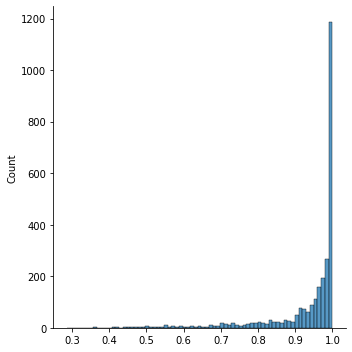

In [10]:
import seaborn as sns
import numpy as np

sns.displot(x=np.max(p_hat,axis=1));

You can see from the plot that a solid majority of classifications are made with at least 90% probability. So if we set a high threshold for classification, we should get few false positives while still getting good recall. In fact, the AUC-ROC score is very high:

In [11]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_te,p_hat,multi_class="ovr")

0.9985961583670022

<div style="max-width:608px"><div style="position:relative;padding-bottom:66.118421052632%"><iframe id="kaltura_player" src="https://cdnapisec.kaltura.com/p/2358381/sp/235838100/embedIframeJs/uiconf_id/43030021/partner_id/2358381?iframeembed=true&playerId=kaltura_player&entry_id=1_mr2gh70i&flashvars[streamerType]=auto&amp;flashvars[localizationCode]=en&amp;flashvars[leadWithHTML5]=true&amp;flashvars[sideBarContainer.plugin]=true&amp;flashvars[sideBarContainer.position]=left&amp;flashvars[sideBarContainer.clickToClose]=true&amp;flashvars[chapters.plugin]=true&amp;flashvars[chapters.layout]=vertical&amp;flashvars[chapters.thumbnailRotator]=false&amp;flashvars[streamSelector.plugin]=true&amp;flashvars[EmbedPlayer.SpinnerTarget]=videoHolder&amp;flashvars[dualScreen.plugin]=true&amp;flashvars[Kaltura.addCrossoriginToIframe]=true&amp;&wid=1_en335xwu" width="608" height="402" allowfullscreen webkitallowfullscreen mozAllowFullScreen allow="autoplay *; fullscreen *; encrypted-media *" sandbox="allow-forms allow-same-origin allow-scripts allow-top-navigation allow-pointer-lock allow-popups allow-modals allow-orientation-lock allow-popups-to-escape-sandbox allow-presentation allow-top-navigation-by-user-activation" frameborder="0" title="Kaltura Player" style="position:absolute;top:0;left:0;width:100%;height:100%"></iframe></div></div>